In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [2]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [3]:
# Paths
data_dir = 'data/training'  # Folder with .tif images
csv_file = 'data/training.csv'  # CSV file with image_id and is_homogeneous


In [4]:
# Load the CSV file
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip()
df.rename(columns={'is_homogenous': 'is_homogeneous'}, inplace=True)


In [5]:
# Create image paths and labels
image_paths = [os.path.join(data_dir, f"{str(image_id).zfill(3)}.tif") for image_id in df['image_id']]
labels = df['is_homogeneous'].values

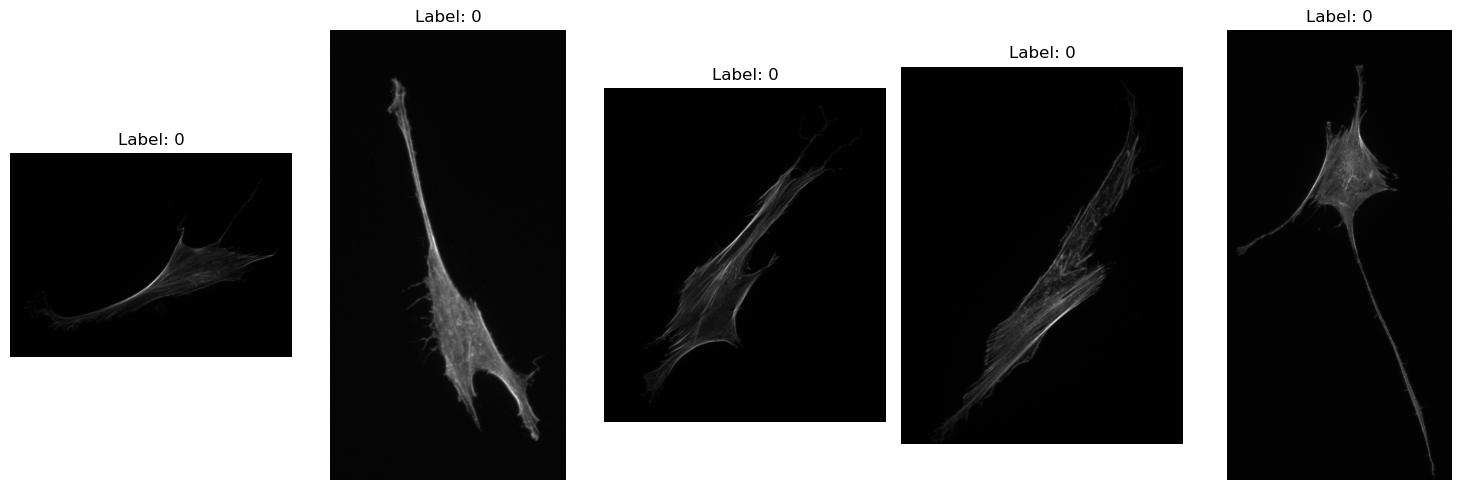

In [6]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Number of random samples to take
num_samples = 5

# Randomly select 5 indices
random_indices = random.sample(range(len(image_paths)), num_samples)

# Plot the selected images and their labels
plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    img_path = image_paths[idx]
    label = labels[idx]
    
    # Load image
    img = mpimg.imread(img_path)
    
    # Create subplot for each image
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img, cmap='gray')  # Assuming grayscale images, adjust cmap if necessary
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


In [7]:
# Stratify split to maintain class distribution
train_paths, val_paths, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

In [8]:
# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

In [9]:
# Separate majority and minority classes
train_paths_majority = [path for path, label in zip(train_paths, y_train) if label == 0]
train_labels_majority = [0] * len(train_paths_majority)

train_paths_minority = [path for path, label in zip(train_paths, y_train) if label == 1]
train_labels_minority = [1] * len(train_paths_minority)


In [10]:
print(f"Majority class samples: {len(train_labels_majority)}")
print(f"Minority class samples: {len(train_labels_minority)}")

Majority class samples: 92
Minority class samples: 19


In [11]:
# Calculate the number of augmented images needed
num_majority_samples = len(train_labels_majority)
num_minority_samples = len(train_labels_minority)
num_augmented_images_needed = num_majority_samples - num_minority_samples


In [12]:
print(f"Number of augmented images needed: {num_augmented_images_needed}")


Number of augmented images needed: 73


In [13]:
augment_times = num_augmented_images_needed // num_minority_samples + 1


In [14]:
augment_times

4

In [15]:
# Transformations for the majority class and original minority class
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),  # Ensure images are tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])   # ImageNet stds
])

In [16]:
# Transformations for the augmented minority class
minority_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  # Ensure images are tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [17]:
# Transformations for validation set
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Ensure images are tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [18]:
class CellDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform  # We will not use transform here

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path)
            print(f"Loading image from: {image_path}")
            print(f"Image type after opening: {type(image)}")
            print(f"Image mode before conversion: {image.mode}")

            # Convert image to NumPy array
            if image.mode.startswith('I;16'):
                numpy_image = np.array(image, dtype=np.uint16)
                # Normalize the image data to range [0, 1]
                numpy_image = numpy_image.astype(np.float32) / 65535.0
            else:
                image = image.convert('RGB')
                numpy_image = np.array(image, dtype=np.float32) / 255.0

            # Convert NumPy array to PyTorch tensor
            if image.mode.startswith('I;'):
                # For grayscale images, add a channel dimension
                numpy_image = np.expand_dims(numpy_image, axis=2)

            # Ensure the image has 3 channels
            if numpy_image.shape[2] == 1:
                numpy_image = np.repeat(numpy_image, 3, axis=2)

            # Transpose the array to match PyTorch's channel order
            numpy_image = np.transpose(numpy_image, (2, 0, 1))

            # Convert to tensor
            tensor_image = torch.from_numpy(numpy_image)

            # Normalize using ImageNet mean and std
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            tensor_image = normalize(tensor_image)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        return tensor_image.float(), label

class AugmentedDataset(Dataset):
    def __init__(self, image_paths, labels, augment_times=1):
        self.image_paths = image_paths
        self.labels = labels
        self.augment_times = augment_times
        # Define augmentation transforms
        self.augmentation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ])

    def __len__(self):
        return len(self.image_paths) * self.augment_times

    def __getitem__(self, idx):
        actual_idx = idx % len(self.image_paths)
        image_path = self.image_paths[actual_idx]
        label = self.labels[actual_idx]

        try:
            image = Image.open(image_path)
            print(f"Loading image from: {image_path}")
            print(f"Image type after opening: {type(image)}")
            print(f"Image mode before conversion: {image.mode}")

            # Convert image to NumPy array
            if image.mode.startswith('I;16'):
                numpy_image = np.array(image, dtype=np.uint16)
                # Normalize the image data to range [0, 1]
                numpy_image = numpy_image.astype(np.float32) / 65535.0
            else:
                image = image.convert('RGB')
                numpy_image = np.array(image, dtype=np.float32) / 255.0

            # Convert NumPy array to PyTorch tensor
            if image.mode.startswith('I;'):
                # For grayscale images, add a channel dimension
                numpy_image = np.expand_dims(numpy_image, axis=2)

            # Ensure the image has 3 channels
            if numpy_image.shape[2] == 1:
                numpy_image = np.repeat(numpy_image, 3, axis=2)

            # Transpose the array to match PyTorch's channel order
            numpy_image = np.transpose(numpy_image, (2, 0, 1))

            # Convert to tensor
            tensor_image = torch.from_numpy(numpy_image)

            # Apply data augmentation
            tensor_image = self.augmentation(tensor_image)
            tensor_image = transforms.ToTensor()(tensor_image)

            # Normalize using ImageNet mean and std
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            tensor_image = normalize(tensor_image)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        return tensor_image.float(), label


In [19]:
# Create datasets
majority_dataset = CellDataset(train_paths_majority, train_labels_majority, transform=train_transform)
augmented_minority_dataset = AugmentedDataset(
    train_paths_minority,
    train_labels_minority,
    transform=minority_augmentation,
    augment_times=augment_times
)

TypeError: __init__() got an unexpected keyword argument 'transform'

In [ ]:
majority_dataset

In [ ]:
# Combine datasets using ConcatDataset
train_dataset = ConcatDataset([majority_dataset, augmented_minority_dataset])


In [ ]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
# Validation dataset and DataLoader
val_dataset = CellDataset(val_paths, y_val, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Test data loading
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print(f"Inputs type: {type(inputs)}, Inputs shape: {inputs.shape}")
    print(f"Labels type: {type(labels)}, Labels shape: {labels.shape}")
    break  # Test with the first batch


In [20]:

# ... [All previous imports and initial setup]

# Updated CellDataset and AugmentedDataset classes
class CellDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path)
            print(f"Loading image from: {image_path}")
            print(f"Image type after opening: {type(image)}")
            print(f"Image mode before conversion: {image.mode}")

            # Convert image to NumPy array
            if image.mode.startswith('I;16'):
                numpy_image = np.array(image, dtype=np.uint16)
                numpy_image = numpy_image.astype(np.float32) / 65535.0
            else:
                image = image.convert('RGB')
                numpy_image = np.array(image, dtype=np.float32) / 255.0

            # Ensure the image has 3 channels
            if numpy_image.ndim == 2:
                numpy_image = np.expand_dims(numpy_image, axis=2)
                numpy_image = np.repeat(numpy_image, 3, axis=2)
            elif numpy_image.shape[2] == 1:
                numpy_image = np.repeat(numpy_image, 3, axis=2)

            # Transpose the array to match PyTorch's channel order
            numpy_image = np.transpose(numpy_image, (2, 0, 1))

            # Convert to tensor
            tensor_image = torch.from_numpy(numpy_image)

            # Normalize using ImageNet mean and std
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            tensor_image = normalize(tensor_image)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        return tensor_image.float(), label

class AugmentedDataset(Dataset):
    def __init__(self, image_paths, labels, augment_times=1):
        self.image_paths = image_paths
        self.labels = labels
        self.augment_times = augment_times
        self.augmentation = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
        ])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.image_paths) * self.augment_times

    def __getitem__(self, idx):
        actual_idx = idx % len(self.image_paths)
        image_path = self.image_paths[actual_idx]
        label = self.labels[actual_idx]

        try:
            image = Image.open(image_path)
            print(f"Loading image from: {image_path}")
            print(f"Image type after opening: {type(image)}")
            print(f"Image mode before conversion: {image.mode}")

            # Convert image to NumPy array
            if image.mode.startswith('I;16'):
                numpy_image = np.array(image, dtype=np.uint16)
                numpy_image = numpy_image.astype(np.float32) / 65535.0
            else:
                image = image.convert('RGB')
                numpy_image = np.array(image, dtype=np.float32) / 255.0

            # Ensure the image has 3 channels
            if numpy_image.ndim == 2:
                numpy_image = np.expand_dims(numpy_image, axis=2)
                numpy_image = np.repeat(numpy_image, 3, axis=2)
            elif numpy_image.shape[2] == 1:
                numpy_image = np.repeat(numpy_image, 3, axis=2)

            # Transpose the array to match PyTorch's channel order
            numpy_image = np.transpose(numpy_image, (2, 0, 1))

            # Convert to tensor
            tensor_image = torch.from_numpy(numpy_image)

            # Apply data augmentation
            tensor_image = self.augmentation(tensor_image)

            # Normalize
            tensor_image = self.normalize(tensor_image)

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            raise e

        return tensor_image.float(), label

# Create datasets
majority_dataset = CellDataset(train_paths_majority, train_labels_majority)
augmented_minority_dataset = AugmentedDataset(
    train_paths_minority,
    train_labels_minority,
    augment_times=augment_times
)

# Combine datasets
train_dataset = ConcatDataset([majority_dataset, augmented_minority_dataset])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation dataset and DataLoader
val_dataset = CellDataset(val_paths, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Rest of your code remains the same...


In [21]:
# Test data loading
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print(f"Inputs type: {type(inputs)}, Inputs shape: {inputs.shape}")
    print(f"Labels type: {type(labels)}, Labels shape: {labels.shape}")
    break  # Test with the first batch


Loading image from: data/training/085.tif
Image type after opening: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Image mode before conversion: I;16B
Error loading image data/training/085.tif: expected np.ndarray (got numpy.ndarray)


TypeError: expected np.ndarray (got numpy.ndarray)